In [1]:
import FundamentalAnalysis as fa 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [4]:
ticker = "XPEV" #ticker name
api = "384de232a09606f8ff4de3489690dc4c" #api key

#get company profile for beta calculation and marketcap
profile = fa.profile(ticker, api)
quote = fa.quote(ticker, api)

#FMP gives the dates reversed and hence the need for
#the .iloc in all the data calls
fra = fa.financial_ratios(ticker, api, period="annual").iloc[:,::-1] #get the annual financial ratios (past 5 years)
frq = fa.financial_ratios(ticker, api, period="quarter").iloc[:,::-1] #get the past 5 quarters

#get the cash flow, income statement, and balance sheet
cf = fa.cash_flow_statement(ticker, api).iloc[:,::-1]
ins = fa.income_statement(ticker, api).iloc[:,::-1]
bs = fa.balance_sheet_statement(ticker, api).iloc[:,::-1]

year = "2019" #set year

In [16]:
bs

,2018,2019
fillingDate,2018-12-31,2019-12-31
acceptedDate,2018-12-31,2019-12-31
period,FY,FY
cashAndCashEquivalents,1626878000,1946931000
shortTermInvestments,3006247000,407844000
cashAndShortTermInvestments,4633125000,2354775000
netReceivables,1087650000,1323817000
inventory,169326000,454116000
otherCurrentAssets,39013000,98241000
totalCurrentAssets,6109043000,4960650000


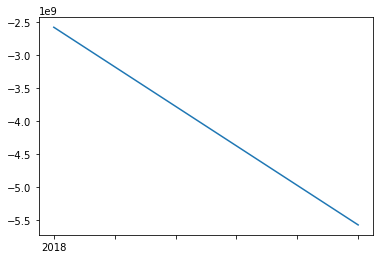

In [15]:
cf.loc["freeCashFlow"].plot()

In [5]:
qoa = fra

#plot out key ratios
qoa.loc["returnOnEquity"].plot(label="ROE")
qoa.loc["debtEquityRatio"].plot(label="D/E")
qoa.loc["freeCashFlowPerShare"].plot(label="FCF")
qoa.loc["grossProfitMargin"].plot(label="Profit Margin")

plt.legend()

KeyError: 'returnOnEquity'

In [16]:
dcf_proj = pd.DataFrame({
    "revenue" : ins.loc["revenue"],
    "netincome" : cf.loc["netIncome"],
    "freecash" : cf.loc["freeCashFlow"]
}).transpose()

dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
rev_change = ins.loc["revenue"].pct_change().mean()
margin_change = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
fcf_change = dcf_proj.loc["FCFr", dcf_proj.loc["FCFr"] > 0].min()

In [17]:
allFVs = []

for p in range(1000):
    startrev = dcf_proj.loc["revenue",year]
    startneti = dcf_proj.loc["netincome",year]
    startfcf = dcf_proj.loc["freecash",year]

    #creating projections for a 5 year dcf model
    Fiveyrev = []
    Fiveyinc = []
    Fiveyfcf = []
    for i in range(5):
        startrev = startrev*(1+np.random.normal(loc=0.15, scale=0.05))
        neti = startrev*(margin_change/100)
        fcf = neti*(fcf_change/100)
        Fiveyrev.append(startrev)
        Fiveyinc.append(neti)
        Fiveyfcf.append(fcf)


    dcf_calc = pd.DataFrame({
        "ProjRev" : Fiveyrev,
        "ProjInc" : Fiveyinc,
        "ProjFCF" : Fiveyfcf
    })

    # tnx = yf.Ticker("^TNX") #use yfinance to get the 10yr treasury bond return
    # rfr = tnx.info["previousClose"] #use previousclose to estimate rfr

    rfr = 0.94

    beta = profile.loc["beta"] #get beta of stock from stock profile
    mktCap = quote.loc["marketCap"] #market cap of stock
    totdebt = bs.loc["totalDebt",year] #total debt
    sharesOut = quote.loc["sharesOutstanding"]
    pg = 0.025

    Rd = ins.loc["interestExpense", year]/totdebt*(1-(ins.loc["incomeTaxExpense",year]/ins.loc["incomeBeforeTax",year]))
    Re = rfr + (beta*(10 - rfr))
    # Wacc = ((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100
    Wacc = np.random.normal(loc=0.075, scale=0.005)

    TV = float(((Fiveyfcf[-1]*(1+pg))/(Wacc - pg)))
    Fiveyfcf.append(TV)

    Fiveyfcfdisc = []

    for i,d in enumerate(Fiveyfcf):
        disc = float(Fiveyfcf[i]) * (1+Wacc)**(1+i)
        Fiveyfcfdisc.append(disc)

    FV = round(float(float(sum(Fiveyfcfdisc))/sharesOut),2)

    allFVs.append(FV)

In [26]:
beta = profile.loc["beta"] #get beta of stock from stock profile
mktCap = quote.loc["marketCap"] #market cap of stock
totdebt = bs.loc["totalDebt",year] #total debt
sharesOut = quote.loc["sharesOutstanding"]
pg = 0.025

Rd = ins.loc["interestExpense", year]/totdebt*(1-(ins.loc["incomeTaxExpense",year]/ins.loc["incomeBeforeTax",year]))
Re = rfr + (beta*(10 - rfr))
Wacc = ((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100

In [27]:
Wacc

0    0.214005
dtype: object

In [28]:
wacklist = []
for i,d in enumerate(["2015","2016","2017","2018","2019"]):
    Rd = ins.loc["interestExpense", d]/totdebt*(1-(ins.loc["incomeTaxExpense",d]/ins.loc["incomeBeforeTax",d]))
    Re = rfr + (beta*(10 - rfr))
    Wacc = float(((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100)
    wacklist.append(Wacc)

In [32]:
np.std(wacklist)
np.mean(wacklist)

0.21401505645978855

Median Fair Value: 19.25


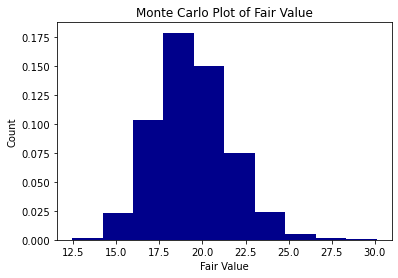

In [18]:
import matplotlib.pyplot as plt

plt.hist(allFVs, density=True, color="darkblue")
plt.title("Monte Carlo Plot of Fair Value")
plt.xlabel("Fair Value")
plt.ylabel("Count")

print("Median Fair Value: {}".format(np.median(allFVs)))

In [51]:
def fairvalue_mont(ticker_name, api_key, sim_number=100, manual_mode = "no", man_initial_revenue=None, man_rev_growth_mean=None, man_rev_growth_stdd=None, RR_mean=0.075, RR_stdd=0.005, risk_free_rate_ticker = "^TNX", risk_free_rate = 0.94, perpGrowth = 0.025, year="2019"):
    """
    This function allows you to run a Monte Carlo Simulation
    to better estimate fair value.

    Set manual_mode to "yes" to enter your own numbers
    for initial revenue (in thousands) and revenue growth (mean and
    standard deviation).  
    Take note that you will still have to provide dataframes 
    since other data like IncomeExpense etc. will still 
    be automatically pulled from the balance sheet.
    """
    
    ticker = ticker_name #ticker name
    api = api_key #api key

    #get company profile for beta calculation and marketcap
    stkProf = fa.profile(ticker, api)
    stkQuote = fa.quote(ticker, api)

    #get the cash flow, income statement, and balance sheet
    stkCash = fa.cash_flow_statement(ticker, api).iloc[:,::-1]
    stkInc = fa.income_statement(ticker, api).iloc[:,::-1]
    stkBal = fa.balance_sheet_statement(ticker, api).iloc[:,::-1]

    allFVs = []

    try:
        tnx = yf.Ticker(risk_free_rate_ticker) 
        rfr = tnx.info["previousClose"] 
    except:
        rfr = risk_free_rate

    for p in range(sim_number):
        if manual_mode == "no":
            dcf_proj = pd.DataFrame({
            "revenue" : stkInc.loc["revenue"],
            "netincome" : stkCash.loc["netIncome"],
            "freecash" : stkCash.loc["freeCashFlow"]
            }).transpose()

            auto_initial_revenue = dcf_proj.loc["revenue",year]

            dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
            dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
            auto_rev_growth_mean = stkInc.loc["revenue"].pct_change().mean()
            auto_rev_growth_stdd = stkInc.loc["revenue"].pct_change().std()
            auto_incomeMargin = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
            auto_revOverfcf = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()

            Fiveyrev = []
            Fiveyinc = []
            Fiveyfcf = []

            for i in range(5):
                auto_initial_revenue = auto_initial_revenue*(1+np.random.normal(loc= auto_rev_growth_mean, scale= auto_rev_growth_stdd))
                neti = auto_initial_revenue*(auto_incomeMargin/100)
                fcf = neti*(auto_revOverfcf/100)
                Fiveyrev.append(auto_initial_revenue)
                Fiveyinc.append(neti)
                Fiveyfcf.append(fcf)

            beta = stkProf.loc["beta"]
            mktCap = stkQuote.loc["marketCap"] 
            totdebt = stkBal.loc["totalDebt",year]
            sharesOut = stkQuote.loc["sharesOutstanding"]
            pg = perpGrowth

            RR_sim = np.random.normal(loc=RR_mean, scale=RR_stdd)
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR_sim - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR_sim)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = round(float(float(sum(Fiveyfcfdisc))/sharesOut),2)
            allFVs.append(FV)
            
                

        elif manual_mode=="yes":
            dcf_proj = pd.DataFrame({
            "revenue" : stkInc.loc["revenue"],
            "netincome" : stkCash.loc["netIncome"],
            "freecash" : stkCash.loc["freeCashFlow"]
            }).transpose()

            dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
            dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
            auto_incomeMargin = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
            auto_revOverfcf = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()

            Fiveyrev = []
            Fiveyinc = []
            Fiveyfcf = []
            for i in range(5):
                man_initial_revenue = man_initial_revenue*(1+np.random.normal(loc= man_rev_growth_mean,scale= man_rev_growth_stdd))
                neti = man_initial_revenue*(auto_incomeMargin/100)
                fcf = neti*(auto_revOverfcf/100)
                Fiveyrev.append(man_initial_revenue)
                Fiveyinc.append(neti)
                Fiveyfcf.append(fcf)

            beta = stkProf.loc["beta"]
            mktCap = stkQuote.loc["marketCap"] 
            totdebt = stkBal.loc["totalDebt",year]
            sharesOut = stkQuote.loc["sharesOutstanding"]
            pg = perpGrowth

            RR_sim = np.random.normal(loc=RR_mean, scale=RR_stdd)
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR_sim - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR_sim)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = round(float(float(sum(Fiveyfcfdisc))/sharesOut),2)
            allFVs.append(FV)

    return allFVs

In [50]:
growth_rate = np.random.normal(loc=0.15, scale=0.0, size=10)
growth_rate

array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

In [54]:
fairvalue_mont(ticker_name="AMD",api_key=api)

[16.62, 13.27, 13.51, 15.22, 20.1, 17.86, 13.96, 9.95, 14.9, 19.99]